IMPORTING MODULES

# Importing libraries

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets ,layers,models
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import *
import dlib
from tensorflow.keras.utils import to_categorical
import numpy as np 
import os 
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import Sequence
# i used a keras model , so i have to use data_utils.Sequence
from keras.utils import data_utils
import matplotlib.image as mpimg
from keras.layers.core import Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,GlobalAveragePooling2D

# Making directories

In [23]:
DATA_DIR = "../input/state-farm-distracted-driver-detection/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [24]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Loading and Analysis

In [25]:
import pandas as pd
file_name = '../input/state-farm-distracted-driver-detection/driver_imgs_list.csv' 
df = pd.read_csv(file_name)
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


**Exploratory Data Analysis**

In [26]:
import plotly.express as px

px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

In [27]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

**Image overview**

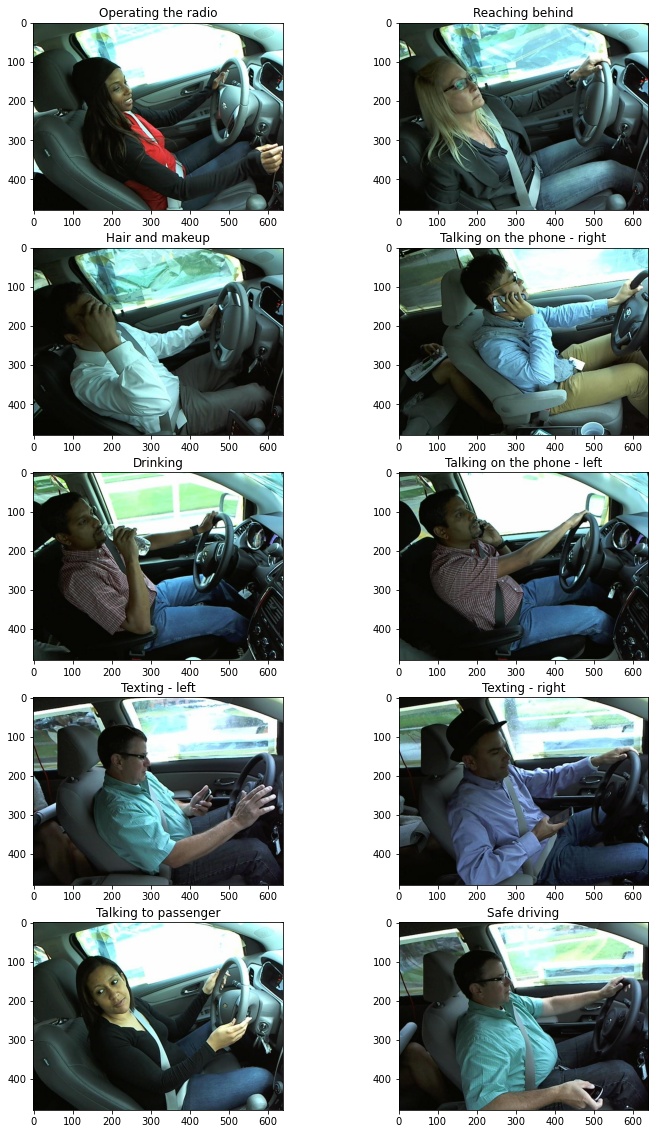

In [28]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [29]:
# Number of unique subjects and classes in the Dataframe
print(df['subject'].nunique())
print(df['classname'].nunique())

26
10


**Data Preparation**

In [30]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

In [31]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:int(id) for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c0': 0, 'c9': 1, 'c2': 2, 'c1': 3, 'c8': 4, 'c7': 5, 'c4': 6, 'c6': 7, 'c5': 8, 'c3': 9}


In [32]:
# Splitting into test and train
data_train = data_train.sample(frac=1)
size = data_train.shape[0]
df = data_train.copy()
df_train = df.iloc[:size - int(0.2*size)]
df_test = data_train.iloc[size - int(0.2*size):]

# Model Preparation

In [33]:
DIM = 256
NB_CHANNELS = 3
NB_CLASSES = 10

In [34]:
def get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256):
    ### Perform data augmentation here
    image_generator = ImageDataGenerator(rescale=1/255 ,rotation_range = 5, shear_range = 0.02,zoom_range = 0.02,
                                         samplewise_center=True, samplewise_std_normalization= True)
    
    ### Create the image generator

    train_generator=image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="Filename",
    y_col="ClassName",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="raw",
    target_size=(target_w,target_h)
)
    valid_generator=image_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="Filename",
    y_col="ClassName",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="raw",
    target_size=(target_w,target_h)
)
    
    return train_generator, valid_generator

In [35]:
data_test.head()

,FileName,ClassName
0,../input/state-farm-distracted-driver-detectio...,test
1,../input/state-farm-distracted-driver-detectio...,test
2,../input/state-farm-distracted-driver-detectio...,test
3,../input/state-farm-distracted-driver-detectio...,test
4,../input/state-farm-distracted-driver-detectio...,test


In [36]:
data_train['ClassName'] = data_train['ClassName'].astype('int')

In [37]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Filename", y_cols = "ClassName", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

Found 17940 validated image filenames.
Found 4484 validated image filenames.


In [38]:
base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), padding="same",input_shape = (DIM , DIM , NB_CHANNELS)))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(3, 3)))
base_model.add(Conv2D(64, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(Conv2D(64, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Conv2D(128, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(Conv2D(128, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(1024))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization())
base_model.add(Dense(10))
base_model.add(Activation("softmax"))
base_model.build((0,256,256,3))
base_model.summary()

2023-01-29 18:03:43.615318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.616294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.617442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.618256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.619066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 64)        3

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.622400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 18:03:43.892696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.893504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 18:03:43.894234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

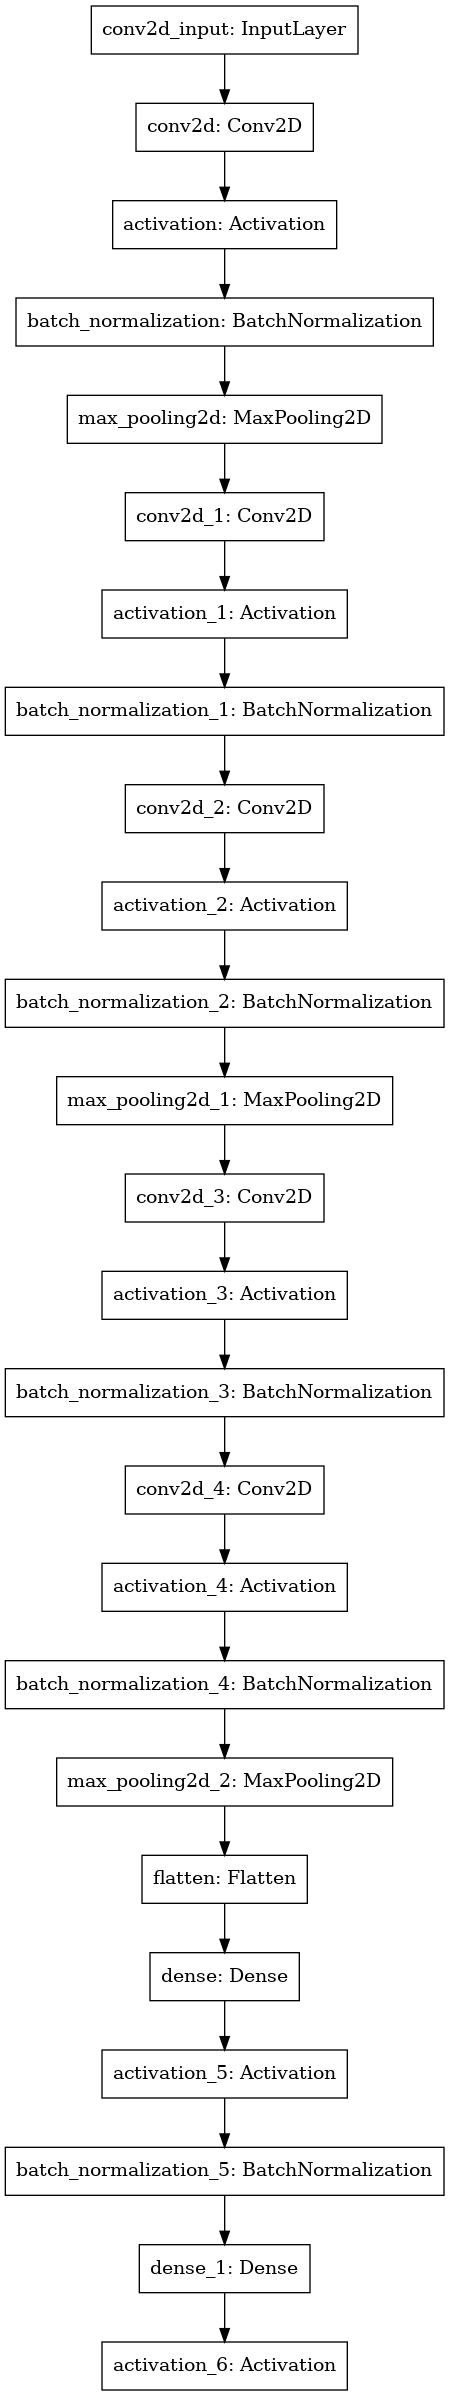

In [39]:
tf.keras.utils.plot_model(
    base_model, to_file='base_model.png'
)

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


base_model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = base_model.fit(train_generator,validation_data = valid_generator, epochs = 7,callbacks=[learning_rate_reduction])

2023-01-29 18:03:50.389069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2023-01-29 18:03:54.864063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


281/281 [==============================] - 626s 2s/step - loss: 0.3141 - accuracy: 0.9177 - val_loss: 1.1432 - val_accuracy: 0.6291
Epoch 2/7
281/281 [==============================] - 474s 2s/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.0555 - val_accuracy: 0.9846
Epoch 3/7
281/281 [==============================] - 466s 2s/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0311 - val_accuracy: 0.9900
Epoch 4/7
281/281 [==============================] - 480s 2s/step - loss: 0.0217 - accuracy: 0.9936 - val_loss: 0.0552 - val_accuracy: 0.9848
Epoch 5/7
281/281 [==============================] - 481s 2s/step - loss: 0.0150 - accuracy: 0.9960 - val_loss: 0.0390 - val_accuracy: 0.9902
Epoch 6/7
281/281 [==============================] - 464s 2s/step - loss: 0.0123 - accuracy: 0.9967 - val_loss: 0.0298 - val_accuracy: 0.9922
Epoch 7/7
281/281 [==============================] - 461s 2s/step - loss: 0.0125 - accuracy: 0.9964 - val_loss: 0.0366 - val_accuracy: 0.9891


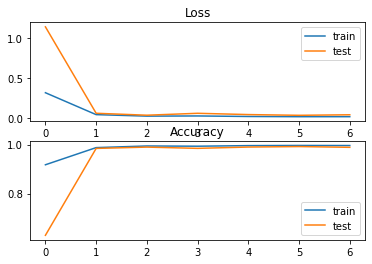

In [41]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()